In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import csv



In [9]:
# Load dataset
housing_modified = pd.read_csv("../data/housing_modified.csv")
x_data = housing_modified[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'GE', 'DIS', 'RAD', 'TAX', 'PRTATIO', 'LSTAT']]
y_data = housing_modified[['PRICE']]

# Standardization
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_data_std = scaler_x.fit_transform(x_data)
y_data_std = scaler_y.fit_transform(y_data)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.hidden1 = nn.Sequential(
            nn.Linear(12, 100),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.predict = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(50, 1)
        )
    
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.predict(x)
        return x




In [10]:
# K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
all_train_losses = []
all_val_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_data_std)):
    print(f"Training Fold {fold+1}/{k}")
    x_train, x_val = x_data_std[train_idx], x_data_std[val_idx]
    y_train, y_val = y_data_std[train_idx], y_data_std[val_idx]
    
    train_data = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_data = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
    
    model = FullyConnectedNN().to(device)
    optimizer = Adam(model.parameters(), lr=0.0001)
    loss_func = nn.MSELoss()
    epochs = 500
    
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = loss_func(output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                loss = loss_func(output, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)
        
        print(f"Fold {fold+1}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    all_train_losses.append(train_loss_list)
    all_val_losses.append(val_loss_list)
    
    # Save loss per fold
    loss_filename = f'../result/Kfold/train_val_loss_fold{fold+1}.csv'
    with open(loss_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Train Loss', 'Validation Loss'])
        for t_loss, v_loss in zip(train_loss_list, val_loss_list):
            writer.writerow([t_loss, v_loss])
    
    # Plot individual loss curves
    plt.figure()
    plt.plot(train_loss_list, label='Train Loss', color='red')
    plt.plot(val_loss_list, label='Validation Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curve Fold {fold+1}')
    plt.grid()
    plt.savefig(f'../result/Kfold/training_loss_fold{fold+1}.png', dpi= 300)
    plt.close()



Training Fold 1/5
Fold 1, Epoch 1, Train Loss: 1.0142, Val Loss: 0.9050
Fold 1, Epoch 2, Train Loss: 0.9313, Val Loss: 0.8647
Fold 1, Epoch 3, Train Loss: 0.9022, Val Loss: 0.8264
Fold 1, Epoch 4, Train Loss: 0.8905, Val Loss: 0.7906
Fold 1, Epoch 5, Train Loss: 0.9360, Val Loss: 0.7575
Fold 1, Epoch 6, Train Loss: 0.8542, Val Loss: 0.7265
Fold 1, Epoch 7, Train Loss: 0.7800, Val Loss: 0.6984
Fold 1, Epoch 8, Train Loss: 0.8174, Val Loss: 0.6712
Fold 1, Epoch 9, Train Loss: 0.7857, Val Loss: 0.6438
Fold 1, Epoch 10, Train Loss: 0.7924, Val Loss: 0.6185
Fold 1, Epoch 11, Train Loss: 0.7722, Val Loss: 0.5960
Fold 1, Epoch 12, Train Loss: 0.7060, Val Loss: 0.5741
Fold 1, Epoch 13, Train Loss: 0.7128, Val Loss: 0.5535
Fold 1, Epoch 14, Train Loss: 0.6299, Val Loss: 0.5354
Fold 1, Epoch 15, Train Loss: 0.6142, Val Loss: 0.5190
Fold 1, Epoch 16, Train Loss: 0.6503, Val Loss: 0.5032
Fold 1, Epoch 17, Train Loss: 0.5729, Val Loss: 0.4882
Fold 1, Epoch 18, Train Loss: 0.5591, Val Loss: 0.4750
F

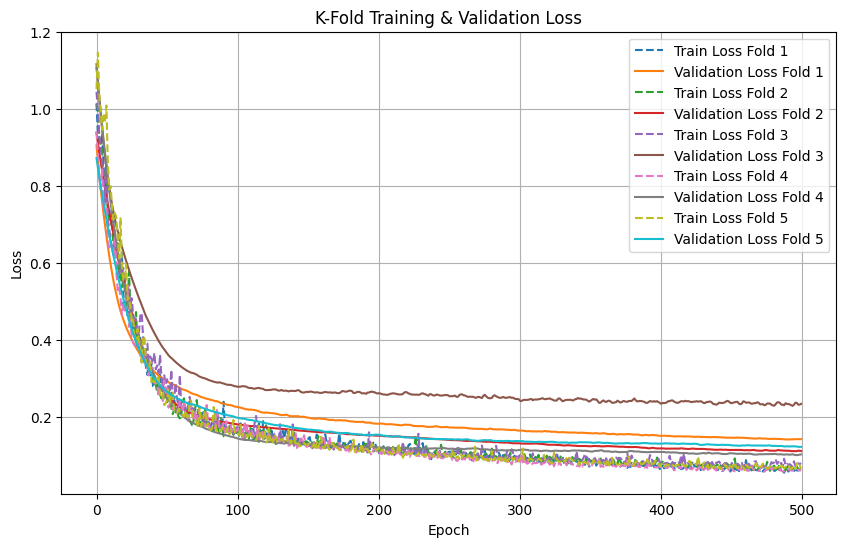

In [11]:
# Merge all loss curves into one plot
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.plot(all_train_losses[i], label=f'Train Loss Fold {i+1}', linestyle='dashed')
    plt.plot(all_val_losses[i], label=f'Validation Loss Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('K-Fold Training & Validation Loss')
plt.grid()
plt.savefig('../result/Kfold/merged_training_loss_dp0.1.png')
plt.show()